In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Install Transformers
!pip install -q transformers
!pip install -q scikit-learn


In [ ]:
# STEP 3: Load the Train and Test datasets

import pandas as pd

# Adjust these paths if needed based on your Drive folder structure
train_path = '/content/drive/MyDrive/INFO 617/INFO 617 Group Project Train Val.xlsx'
test_path = '/content/drive/MyDrive/INFO 617/INFO 617_Group Project Test Set.xlsx'

# Load datasets
train_df = pd.read_excel(train_path)
test_df = pd.read_excel(test_path)

# Quick preview to confirm
print("Train Dataset Preview:")
print(train_df.head())

print("\nTest Dataset Preview:")
print(test_df.head())

# Check columns
print("\nTrain Columns:", train_df.columns)
print("Test Columns:", test_df.columns)


Train Dataset Preview:
                                            Sentence      Label
0                                             Hello,      GREET
1   the rubella virus IgM was detected at around ...     REPEAT
2  which has a 50% chance of causing intrauterine...  DIAGNOISE
3  Intrauterine infection can lead to risks such ...    EXPLAIN
4  Please note that these risks may or may not oc...    EXPLAIN

Test Dataset Preview:
                                            Sentence      Label
0  I have calculated it for you, and your BMI is ...  DIAGNOISE
1  In this case, you need to eat more carbohydrat...      TREAT
2  Normally, you should consume 6-8 liang of stap...      TREAT
3  With this, your weight should increase by 8 li...    EXPLAIN
4  When dining outside or buying takeaway, you sh...      TREAT

Train Columns: Index(['Sentence', 'Label'], dtype='object')
Test Columns: Index(['Sentence', 'Label'], dtype='object')


In [ ]:
# STEP 4: Medium-Strength Data Augmentation

import random

# Functions for augmentation
def synonym_replacement(sentence, p=0.25):
    # List of common clinical synonym replacements (expandable)
    replacements = {
        'diagnosis': 'assessment',
        'treatment': 'therapy',
        'infection': 'contamination',
        'patient': 'individual',
        'consultation': 'meeting',
        'support': 'assistance',
        'risk': 'chance',
        'explain': 'clarify',
        'repeat': 'reiterate',
        'receive': 'obtain'
    }
    words = sentence.split()
    new_words = []
    for word in words:
        if random.random() < p and word.lower() in replacements:
            new_words.append(replacements[word.lower()])
        else:
            new_words.append(word)
    return ' '.join(new_words)

def random_deletion(sentence, p=0.10):
    words = sentence.split()
    if len(words) == 1:
        return sentence
    new_words = [word for word in words if random.random() > p]
    if not new_words:
        return random.choice(words)
    return ' '.join(new_words)

def random_swap(sentence, p=0.10):
    words = sentence.split()
    n = max(1, int(len(words) * p))
    for _ in range(n):
        idx1 = random.randint(0, len(words) - 1)
        idx2 = random.randint(0, len(words) - 1)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def medium_augment(sentence):
    sentence = synonym_replacement(sentence)
    sentence = random_deletion(sentence)
    sentence = random_swap(sentence)
    return sentence

# Start augmenting rare classes
rare_classes = ['FUTURE_SUPPORT', 'REQUEST_INFORMATION', 'WISH', 'REPEAT', 'REMIND']

augmented_train_df = train_df.copy()

for label in rare_classes:
    subset = train_df[train_df['Label'] == label]
    n_aug = max(20, int(len(subset) * 0.7))  # Augment ~70% more examples
    print(f"Augmenting {label}: {len(subset)} examples -> +{n_aug} new examples")
    for _ in range(n_aug):
        original_sentence = subset.sample(1).iloc[0]['Sentence']
        augmented_sentence = medium_augment(original_sentence)
        augmented_train_df = pd.concat([
            augmented_train_df,
            pd.DataFrame({'Sentence': [augmented_sentence], 'Label': [label]})
        ], ignore_index=True)

print(f"\nOriginal train size: {len(train_df)}")
print(f"Augmented train size: {len(augmented_train_df)}")


Augmenting FUTURE_SUPPORT: 36 examples -> +25 new examples
Augmenting REQUEST_INFORMATION: 55 examples -> +38 new examples
Augmenting WISH: 64 examples -> +44 new examples
Augmenting REPEAT: 86 examples -> +60 new examples
Augmenting REMIND: 78 examples -> +54 new examples

Original train size: 4030
Augmented train size: 4251


In [ ]:
# STEP 5: Encode Labels into IDs

# Create Label to ID mapping
label_to_id = {label: idx for idx, label in enumerate(sorted(augmented_train_df['Label'].unique()))}
id_to_label = {v: k for k, v in label_to_id.items()}
print("Label to ID mapping:")
print(label_to_id)

# Encode train data
augmented_train_df['label_id'] = augmented_train_df['Label'].map(label_to_id)

# Encode test data
test_df['label_id'] = test_df['Label'].map(label_to_id)

# Quick check
print("\nAugmented Train dataset after encoding:")
print(augmented_train_df.head())

print("\nTest dataset after encoding:")
print(test_df.head())


Label to ID mapping:
{'CONSOLE': 0, 'DIAGNOISE': 1, 'EXPLAIN': 2, 'FUTURE_SUPPORT': 3, 'GREET': 4, 'QUES': 5, 'RECEIVE': 6, 'REFERRAL': 7, 'REMIND': 8, 'REPEAT': 9, 'REQUEST_INFORMATION': 10, 'THANK': 11, 'TREAT': 12, 'WAIT': 13, 'WISH': 14}

Augmented Train dataset after encoding:
                                            Sentence      Label  label_id
0                                             Hello,      GREET         4
1   the rubella virus IgM was detected at around ...     REPEAT         9
2  which has a 50% chance of causing intrauterine...  DIAGNOISE         1
3  Intrauterine infection can lead to risks such ...    EXPLAIN         2
4  Please note that these risks may or may not oc...    EXPLAIN         2

Test dataset after encoding:
                                            Sentence      Label  label_id
0  I have calculated it for you, and your BMI is ...  DIAGNOISE         1
1  In this case, you need to eat more carbohydrat...      TREAT        12
2  Normally, you shou

In [ ]:
# STEP 6: Calculate Class Weights for Focal Loss

import torch
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract labels
train_labels = augmented_train_df['label_id'].values

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                      classes=np.unique(train_labels),
                                      y=train_labels)

class_weights = torch.tensor(class_weights, dtype=torch.float)

# Display nicely
for idx, weight in enumerate(class_weights):
    print(f"Class: {id_to_label[idx]:<22} |  Weight: {weight:.4f}")


Class: CONSOLE                |  Weight: 3.6333
Class: DIAGNOISE              |  Weight: 0.7438
Class: EXPLAIN                |  Weight: 0.2671
Class: FUTURE_SUPPORT         |  Weight: 4.6459
Class: GREET                  |  Weight: 2.3617
Class: QUES                   |  Weight: 1.0614
Class: RECEIVE                |  Weight: 2.5764
Class: REFERRAL               |  Weight: 1.2766
Class: REMIND                 |  Weight: 2.1470
Class: REPEAT                 |  Weight: 1.9411
Class: REQUEST_INFORMATION    |  Weight: 3.0473
Class: THANK                  |  Weight: 1.9545
Class: TREAT                  |  Weight: 0.2386
Class: WAIT                   |  Weight: 2.0388
Class: WISH                   |  Weight: 2.6241


In [ ]:
# STEP 7: Load DeBERTa-v3-base Model and Tokenizer

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig

# Model name
model_name = 'microsoft/deberta-v3-base'

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model config
config = AutoConfig.from_pretrained(model_name, num_labels=len(label_to_id))

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

# Move model to GPU/CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f" DeBERTa-v3-base model loaded to device: {device}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 DeBERTa-v3-base model loaded to device: cuda


In [ ]:
# STEP 8: Create Dataset Class and Dataloaders

from torch.utils.data import Dataset, DataLoader

# Create a custom Dataset
class CustomDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = str(self.sentences[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 60
BATCH_SIZE = 12

# Create Train and Test datasets
train_dataset = CustomDataset(
    sentences=augmented_train_df['Sentence'].to_numpy(),
    labels=augmented_train_df['label_id'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = CustomDataset(
    sentences=test_df['Sentence'].to_numpy(),
    labels=test_df['label_id'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# Create Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Created TrainLoader with {len(train_loader)} batches.")
print(f"✅ Created TestLoader with {len(test_loader)} batches.")


✅ Created TrainLoader with 355 batches.
✅ Created TestLoader with 99 batches.


In [ ]:
# STEP 9: Define Mixed Loss (Focal + CrossEntropy)

import torch.nn as nn

# Define FocalLoss class
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# CrossEntropy Loss part
cross_entropy_loss = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Mixed Loss Class
class MixedLoss(nn.Module):
    def __init__(self, alpha=0.8):
        super(MixedLoss, self).__init__()
        self.focal = FocalLoss(alpha=class_weights.to(device), gamma=2.0)
        self.cross_entropy = cross_entropy_loss
        self.alpha = alpha

    def forward(self, inputs, targets):
        focal = self.focal(inputs, targets)
        ce = self.cross_entropy(inputs, targets)
        return self.alpha * focal + (1 - self.alpha) * ce

# Initialize the Mixed Loss
loss_fn = MixedLoss(alpha=0.8)

print(" Mixed Focal + CrossEntropy Loss initialized!")


 Mixed Focal + CrossEntropy Loss initialized!


In [ ]:
# STEP 10: Setup Optimizer, Scheduler, and Epochs

from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

# Optimizer with smaller learning rate
optimizer = AdamW(model.parameters(), lr=8e-6)

# Number of training epochs
epochs = 15  # Early Stopping will stop earlier if needed

# Updated Scheduler
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(" Optimizer and Scheduler setup completed!")


 Optimizer and Scheduler setup completed!


In [ ]:
# STEP 11: Training Loop with Mixed Loss + Early Stopping

from sklearn.metrics import accuracy_score
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
patience = 2  # Early stopping patience
early_stop_counter = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # Training
    model.train()
    total_train_loss = 0
    true_labels_train = []
    pred_labels_train = []

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )
        logits = outputs.logits
        loss = loss_fn(logits, batch['labels'])

        total_train_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        true_labels_train.extend(batch['labels'].detach().cpu().numpy())
        pred_labels_train.extend(preds.detach().cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = accuracy_score(true_labels_train, pred_labels_train)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    total_val_loss = 0
    true_labels_val = []
    pred_labels_val = []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            logits = outputs.logits
            loss = loss_fn(logits, batch['labels'])

            total_val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            true_labels_val.extend(batch['labels'].detach().cpu().numpy())
            pred_labels_val.extend(preds.detach().cpu().numpy())

    avg_val_loss = total_val_loss / len(test_loader)
    val_acc = accuracy_score(true_labels_val, pred_labels_val)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_deberta_model.pt')
        print(" Validation loss decreased! Model saved.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(" Early stopping triggered!")
            break



Epoch 1/15
Train Loss: 0.1214 | Train Acc: 0.8829
Val Loss:   0.4081 | Val Acc:   0.8265
 Validation loss decreased! Model saved.

Epoch 2/15
Train Loss: 0.0804 | Train Acc: 0.9097
Val Loss:   0.4502 | Val Acc:   0.8239

Epoch 3/15
Train Loss: 0.0596 | Train Acc: 0.9346
Val Loss:   0.4604 | Val Acc:   0.8130
 Early stopping triggered!


In [ ]:
# STEP 12: Load Best Model and Evaluate

# Load best saved weights
model.load_state_dict(torch.load('best_deberta_model.pt'))

# Move model to evaluation mode
model.eval()

# Inference on Test Set
true_labels = []
pred_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        true_labels.extend(batch['labels'].cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

from sklearn.metrics import classification_report, accuracy_score

# Print overall Test Accuracy
test_accuracy = accuracy_score(true_labels, pred_labels)
print(f"\n Test Accuracy: {test_accuracy:.4f}")

# Detailed Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=[id_to_label[i] for i in range(len(label_to_id))]))



 Test Accuracy: 0.8265

Classification Report:
                     precision    recall  f1-score   support

            CONSOLE       0.61      0.93      0.74        27
          DIAGNOISE       0.77      0.75      0.76       119
            EXPLAIN       0.80      0.76      0.78       316
     FUTURE_SUPPORT       1.00      0.75      0.86         8
              GREET       1.00      0.97      0.98        29
               QUES       0.99      0.97      0.98       109
            RECEIVE       0.95      0.97      0.96        37
           REFERRAL       0.68      0.96      0.80        74
             REMIND       0.70      0.90      0.79        21
             REPEAT       0.63      0.57      0.60        30
REQUEST_INFORMATION       0.71      0.60      0.65        20
              THANK       0.91      0.95      0.93        43
              TREAT       0.86      0.79      0.82       281
               WAIT       0.93      0.96      0.94        52
               WISH       0.95      

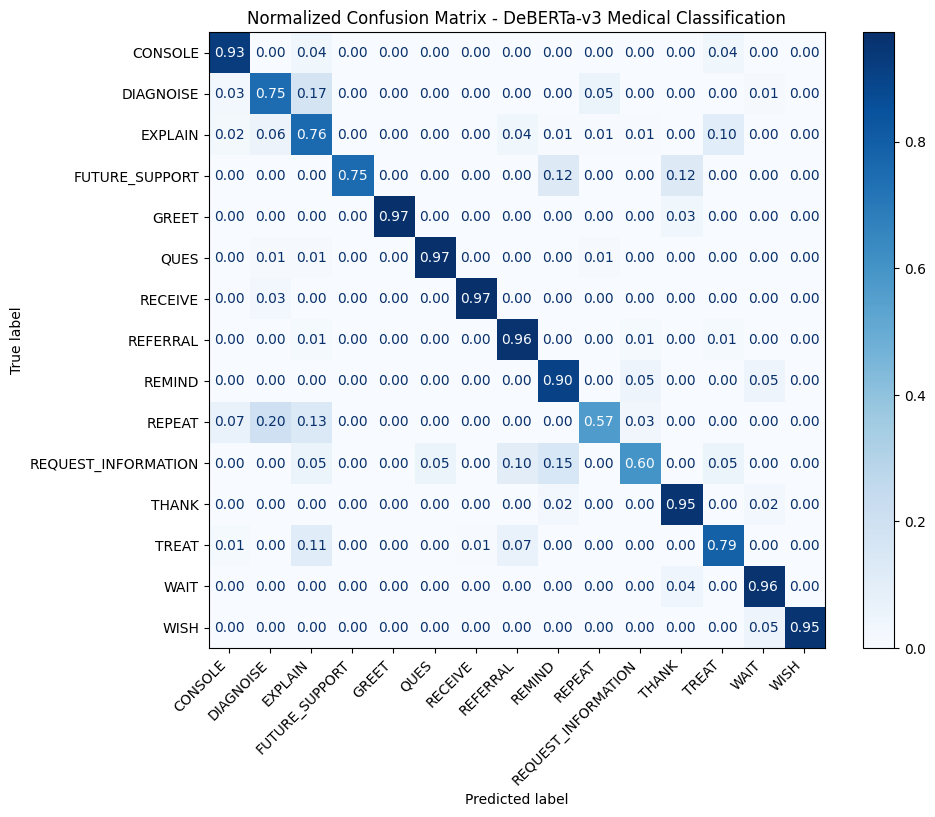

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Normalize it (important for imbalanced datasets)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create display
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[id_to_label[i] for i in range(len(label_to_id))])

disp.plot(cmap='Blues', ax=ax, values_format=".2f")
plt.title("Normalized Confusion Matrix - DeBERTa-v3 Medical Classification")
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.show()


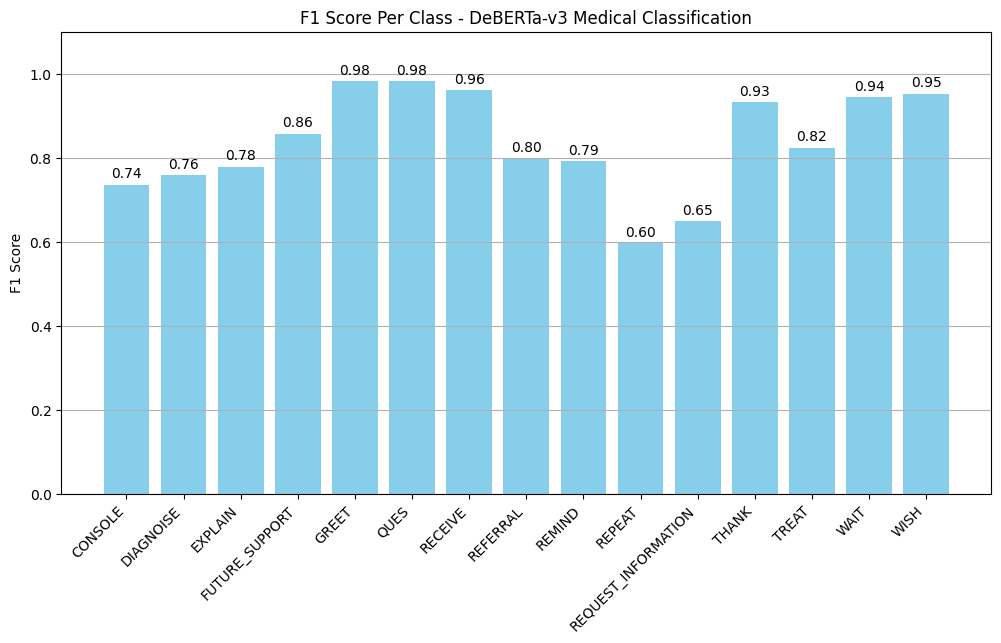

In [ ]:
# F1 Score Per Class Plot (Fixed)

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Generate classification report dictionary
report_dict = classification_report(true_labels, pred_labels, output_dict=True)

# Extract F1-scores for each class (matching the correct keys)
f1_scores = []
class_names = []

for i in range(len(label_to_id)):
    class_name = id_to_label[i]
    class_names.append(class_name)
    f1_scores.append(report_dict[str(i)]['f1-score'])  # Notice str(i) here ✅

# Create bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, f1_scores, color='skyblue')

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.ylim(0, 1.1)
plt.xticks(rotation=45, ha='right')
plt.title('F1 Score Per Class - DeBERTa-v3 Medical Classification')
plt.ylabel('F1 Score')
plt.grid(axis='y')
plt.show()


In [ ]:
# DEMO: Single Sentence Prediction

def predict_single_sentence(sentence, model, tokenizer, max_len=60):
    model.eval()

    # Tokenize input sentence
    encoding = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_label_id = torch.argmax(logits, dim=1).item()

    predicted_label = id_to_label[predicted_label_id]
    return predicted_label

# Example usage:
test_sentence = "Please make sure you take your medicines on time."
predicted_label = predict_single_sentence(test_sentence, model, tokenizer)

print(f" Input Sentence: {test_sentence}")
print(f" Predicted Label: {predicted_label}")


 Input Sentence: Please make sure you take your medicines on time.
 Predicted Label: TREAT


In [ ]:
 #LIVE Typing Demo: Predict Sentence Label

def predict_single_sentence(sentence, model, tokenizer, max_len=60):
    model.eval()

    # Tokenize input
    encoding = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_label_id = torch.argmax(logits, dim=1).item()

    predicted_label = id_to_label[predicted_label_id]
    return predicted_label

# Typing loop
while True:
    user_input = input("  Type a medical sentence (or type 'exit' to stop): ")
    if user_input.lower() == 'exit':
        print(" Exiting prediction loop. Great work!")
        break

    prediction = predict_single_sentence(user_input, model, tokenizer)
    print(f" Predicted Label: {prediction}\n")

 Predicted Label: TREAT

 Predicted Label: DIAGNOISE

